In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist, mnist_transform
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [3]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

train = datasets.MNIST('../data/MNIST/train', train=True, download=True, transform=mnist_transform)
test = datasets.MNIST('../data/MNIST/test', train=False, download=True, transform=mnist_transform)

trainset = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=128, shuffle=True)

# 1. Обучить многослойный автокодировщик
* отрисовать классы в латентном представлении автокодировщика с двумерным латентным слоем </br>
* сделать tSNE над 32-мерным латентным слоем

In [4]:
class Net_2l(nn.Module):
    
    class Encoder(nn.Module):
        def __init__(self, latent_size=10):
            super().__init__()
            self.fc1 = nn.Linear(28*28, 32)
            self.fc2 = nn.Linear(32, latent_size)

        def forward(self, x):
            x = self.fc1(x)
            x = F.relu(x)          
            x = self.fc2(x)
            # В последнем слое оставляем тангенс для контроля диапазона
            x = torch.tanh(x)
            
            return x
    
    class Decoder(nn.Module):
        def __init__(self, latent_size=10):
            super().__init__()
            self.fc1 = nn.Linear(latent_size, 32)
            self.fc2 = nn.Linear(32, 28*28)

        def forward(self, x):
            x = self.fc1(x)
            x = F.relu(x)
            x = self.fc2(x)
            # В последнем слое оставляем тангенс для контроля диапазона
            x = torch.tanh(x)
            
            return x
    
    def __init__(self, latent_size=10, loss=F.mse_loss, lr=1e-4, l2=0.):
        super().__init__()
        self.latent_size = latent_size
        self.E = self.Encoder(latent_size=latent_size)
        self.D = self.Decoder(latent_size=latent_size)
        self.loss_fn = loss
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
        
    def encode(self, x):
        with torch.no_grad():
            return self.E(x)
        
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

## Обучим 3 модели с разным размером скрытого слоя, и сравним качество

In [5]:
models = [
    Net_2l(latent_size=32).cuda(),
    Net_2l(latent_size=10).cuda(),
    Net_2l(latent_size=2).cuda()
]
epochs = 100
loss__ = []

for e in range(epochs):
    loss_ = []
    for model in models:
        for data, _ in trainset:
            model.optim.zero_grad()
            output = model(data.cuda())
            loss = model.loss(data.view(-1, 28*28).cuda(), output.cuda())
            loss.backward()
            model.optim.step()

        for test_data, _ in testset:
            with torch.no_grad():
                output = model(test_data.cuda())
                loss = model.loss(test_data.view(-1, 28*28).cuda(), output.cuda())
        else:
            loss_.append(loss)
      
    loss__.append(loss_)
    print("epoch %d. Losses: %.3f %.3f %.3f" % (e+1, *loss_))

epoch 1. Losses: 0.306 0.321 0.403
epoch 2. Losses: 0.237 0.268 0.289
epoch 3. Losses: 0.221 0.251 0.272
epoch 4. Losses: 0.179 0.220 0.254
epoch 5. Losses: 0.162 0.228 0.249
epoch 6. Losses: 0.147 0.201 0.246
epoch 7. Losses: 0.140 0.189 0.227
epoch 8. Losses: 0.134 0.185 0.238
epoch 9. Losses: 0.127 0.171 0.241
epoch 10. Losses: 0.110 0.181 0.246
epoch 11. Losses: 0.122 0.178 0.252
epoch 12. Losses: 0.096 0.157 0.262
epoch 13. Losses: 0.099 0.160 0.215
epoch 14. Losses: 0.101 0.150 0.233
epoch 15. Losses: 0.115 0.133 0.197
epoch 16. Losses: 0.094 0.125 0.217
epoch 17. Losses: 0.089 0.185 0.241
epoch 18. Losses: 0.089 0.135 0.208
epoch 19. Losses: 0.106 0.131 0.218
epoch 20. Losses: 0.082 0.135 0.225
epoch 21. Losses: 0.099 0.131 0.224
epoch 22. Losses: 0.079 0.139 0.204
epoch 23. Losses: 0.061 0.114 0.231
epoch 24. Losses: 0.065 0.135 0.216
epoch 25. Losses: 0.083 0.116 0.181
epoch 26. Losses: 0.084 0.125 0.207
epoch 27. Losses: 0.072 0.117 0.177
epoch 28. Losses: 0.082 0.107 0.219
e

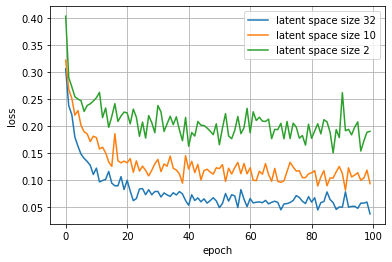

In [6]:
plt.plot(np.array(loss__)[:, 0], label='latent space size 32')
plt.plot(np.array(loss__)[:, 1], label='latent space size 10')
plt.plot(np.array(loss__)[:, 2], label='latent space size 2')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

### Выводы:
* Ожидаемо, больший размер скрытого слоя позволяет лучше автокодировать изображение.
* После 20й эпохи обучение резко замедляется. Явный прогресс виден только для размера скрытого слоя 32. По всей видимости, это объясняется большим числом тренируемых параметров модели.

## Теперь отрисуем изображения, полученные каждой из моделей.

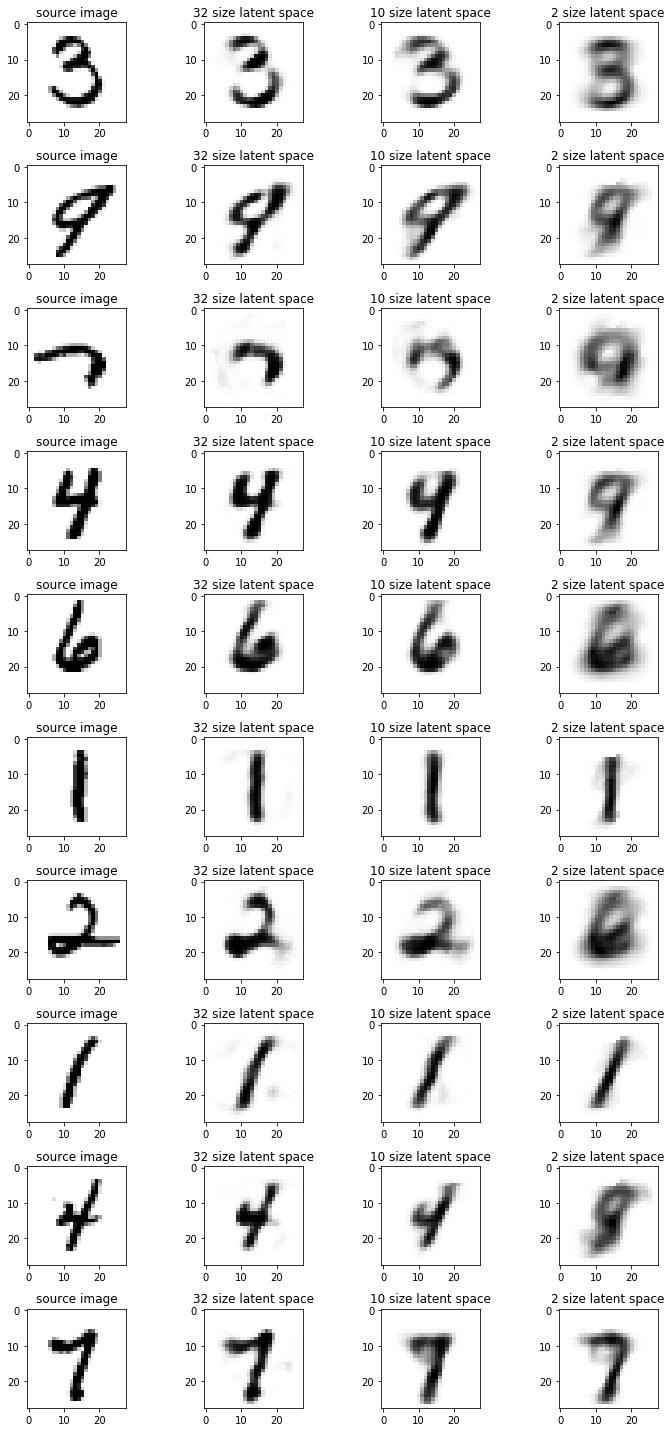

In [7]:
f = plt.figure(figsize=(10, 20))
ncols = 4
plot_imgs = 10

data_src, labels = next(iter(testset))
data32 = models[0](data_src.cuda()).cpu().view(-1, 1, 28, 28)
data10 = models[1](data_src.cuda()).cpu().view(-1, 1, 28, 28)
data2 = models[2](data_src.cuda()).cpu().view(-1, 1, 28, 28)

for i, (im1, im2, im3, im4) in enumerate(zip(data_src, data32, data10, data2)):
    if i >= plot_imgs:
        break    
    ax = f.add_subplot(plot_imgs, ncols, i*ncols+1)
    ax.set_title('source image')
    plt.imshow(im1.view(28, 28).detach().numpy(), cmap = matplotlib.cm.binary)
    ax = f.add_subplot(plot_imgs, ncols, i*ncols+2)
    ax.set_title('32 size latent space')
    plt.imshow(im2.view(28, 28).detach().numpy(), cmap = matplotlib.cm.binary)
    ax = f.add_subplot(plot_imgs, ncols, i*ncols+3)
    ax.set_title('10 size latent space')
    plt.imshow(im3.view(28, 28).detach().numpy(), cmap = matplotlib.cm.binary)
    ax = f.add_subplot(plot_imgs, ncols, i*ncols+4)
    ax.set_title('2 size latent space')
    plt.imshow(im4.view(28, 28).detach().numpy(), cmap = matplotlib.cm.binary)
    
plt.tight_layout()

## Отрисуем коды изображений на диаграммах расеяния

* Латентные представления размерности 2 мы можем напрямую нанести на плоскость, и посмотреть, насколько тяжела жизнь декодера, который должен делать многоклассовую классификацию в этом пространстве.
* Латентные представления размерности 32 необходимо преобразовать в размерность 2 с помощью какого-нибудь известного метода понижения размрности(например, TSNE), прежде чем отрисовывать.

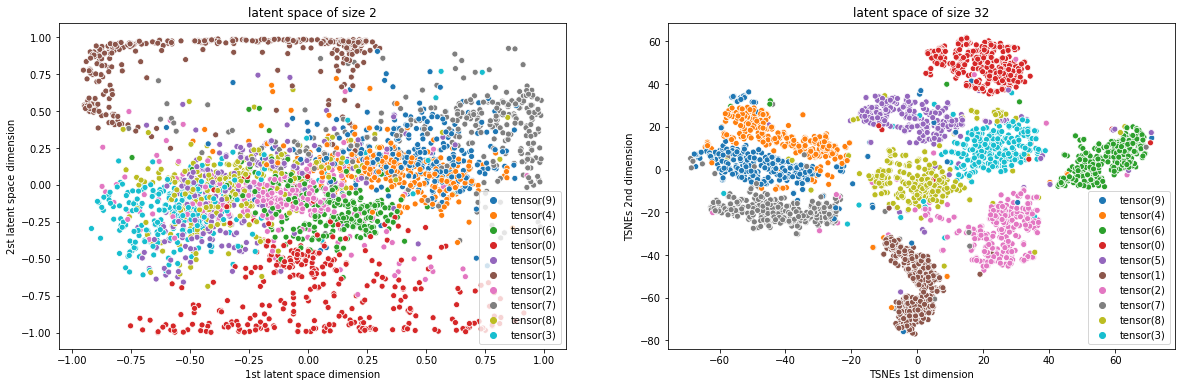

In [8]:
get_numpy_from_tensor = lambda x: x.cpu().detach().numpy()

very_large_batch = torch.utils.data.DataLoader(test, batch_size=3000, shuffle=True)
very_large_batch, labels = next(iter(very_large_batch))
very_large_batch = very_large_batch.view(-1, 28*28).cuda()

hidden_repr_2 = get_numpy_from_tensor(models[2].E(very_large_batch))
hidden_repr_32 = get_numpy_from_tensor(models[0].E(very_large_batch))
tsne = TSNE()
hidden_repr_32_embed = TSNE().fit_transform(hidden_repr_32)

f = plt.figure(figsize=(20, 6))

ax = f.add_subplot(121)
ax.set_title('latent space of size 2')
ax.set_xlabel('1st latent space dimension')
ax.set_ylabel('2st latent space dimension')
sns.scatterplot(hidden_repr_2[:, 0], hidden_repr_2[:, 1], hue=[str(l) for l in labels], ax=ax)
ax = f.add_subplot(122)
ax.set_title('latent space of size 32')
ax.set_xlabel('TSNE''s 1st dimension')
ax.set_ylabel('TSNE''s 2nd dimension')
sns.scatterplot(hidden_repr_32_embed[:, 0], hidden_repr_32_embed[:, 1], hue=[str(l) for l in labels], ax=ax)

plt.show()

### Выводы:
* Латентные представления размерности 2 для разных классов хотя и сохраняют некоторую структуру, всё же довольно сильно перемешаны, что объясняет то, что декодер часто рисует объект другого класса, чем исходный. Задача разделения объектов в этом прстранстве признаков трудна, декодер будет часто ошибаться.
* Латентные представления размерности 32 после понижения размерности выглядят гораздо лучше.
* Это наводит на мысль попытаться обучить декодер на них.

In [9]:
epochs = 10
dec = Net_2l.Decoder(latent_size=2).cuda()
loss_ = []
adam = optim.Adam(dec.parameters(), lr=1e-4)

for e in range(epochs):
    for data, _ in trainset:
        codes32 = get_numpy_from_tensor(models[0].E(data.view(-1, 28*28).cuda()))
        codes2 = torch.tensor(tsne.fit_transform(codes32))

        adam.zero_grad()
        output = dec(codes2.cuda())
        loss = F.mse_loss(data.view(-1, 28*28).cuda(), output.cuda())
        loss.backward()
        adam.step()

    for test_data, _ in testset:
        with torch.no_grad():
            codes32 = get_numpy_from_tensor(models[0].E(test_data.view(-1, 28*28).cuda()))
            codes2 = torch.tensor(tsne.fit_transform(codes32))

            output = dec(codes2.cuda())
            loss = model.loss(test_data.view(-1, 28*28).cuda(), output.cuda())
    else:
        loss_.append(loss)
      
    print("epoch %d. Loss: %.3f" % (e+1, loss))

epoch 1. Loss: 0.540
epoch 2. Loss: 0.457
epoch 3. Loss: 0.443
epoch 4. Loss: 0.349
epoch 5. Loss: 0.438
epoch 6. Loss: 0.528
epoch 7. Loss: 0.470
epoch 8. Loss: 0.503
epoch 9. Loss: 0.353
epoch 10. Loss: 0.424


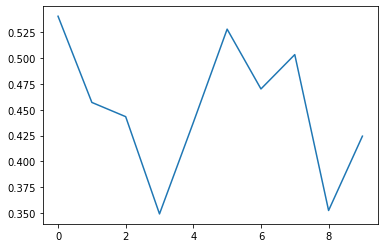

In [10]:
# Почему-то ничего не получается(
plt.plot(loss_)

# Обучить шумный автокодировщик:
* Добавить ко входным данным нормальный шум
* Сделать отражение части изображения
* Отрисовать карты активаций нейронов первого слоя

### Добавить ко входным данным нормальный шум

In [11]:
def salt_tensor(t, thimbleful):
    
    scaler = MinMaxScaler(feature_range=(-1, 1))
    shape = t.shape
    
    t = batch + (torch.rand(shape)-.5)*thimbleful
    t = t.view(-1, 1)
    t = scaler.fit_transform(t)
    t = torch.tensor(t, dtype=torch.float32)
    t = t.view(shape)
    
    return t

reconstruct = lambda t: models[0](t.cuda()).view(-1, 28, 28).cpu().detach()    

testset = torch.utils.data.DataLoader(test, batch_size=10, shuffle=True)

batch, _ = next(iter(testset))
batch = batch.view(-1, 28, 28)

batch_salted_1 = salt_tensor(batch, 1)
batch_salted_3 = salt_tensor(batch, 3)
batch_salted_5 = salt_tensor(batch, 5)

batch_reconstructed = reconstruct(batch)
batch_desalted_1 = reconstruct(batch_salted_1)
batch_desalted_3 = reconstruct(batch_salted_3)
batch_desalted_5 = reconstruct(batch_salted_5)

batches = [batch, batch_salted_1, batch_salted_3, batch_salted_5]
images = [batch, batch_reconstructed, batch_desalted_1, batch_desalted_3, batch_desalted_5]

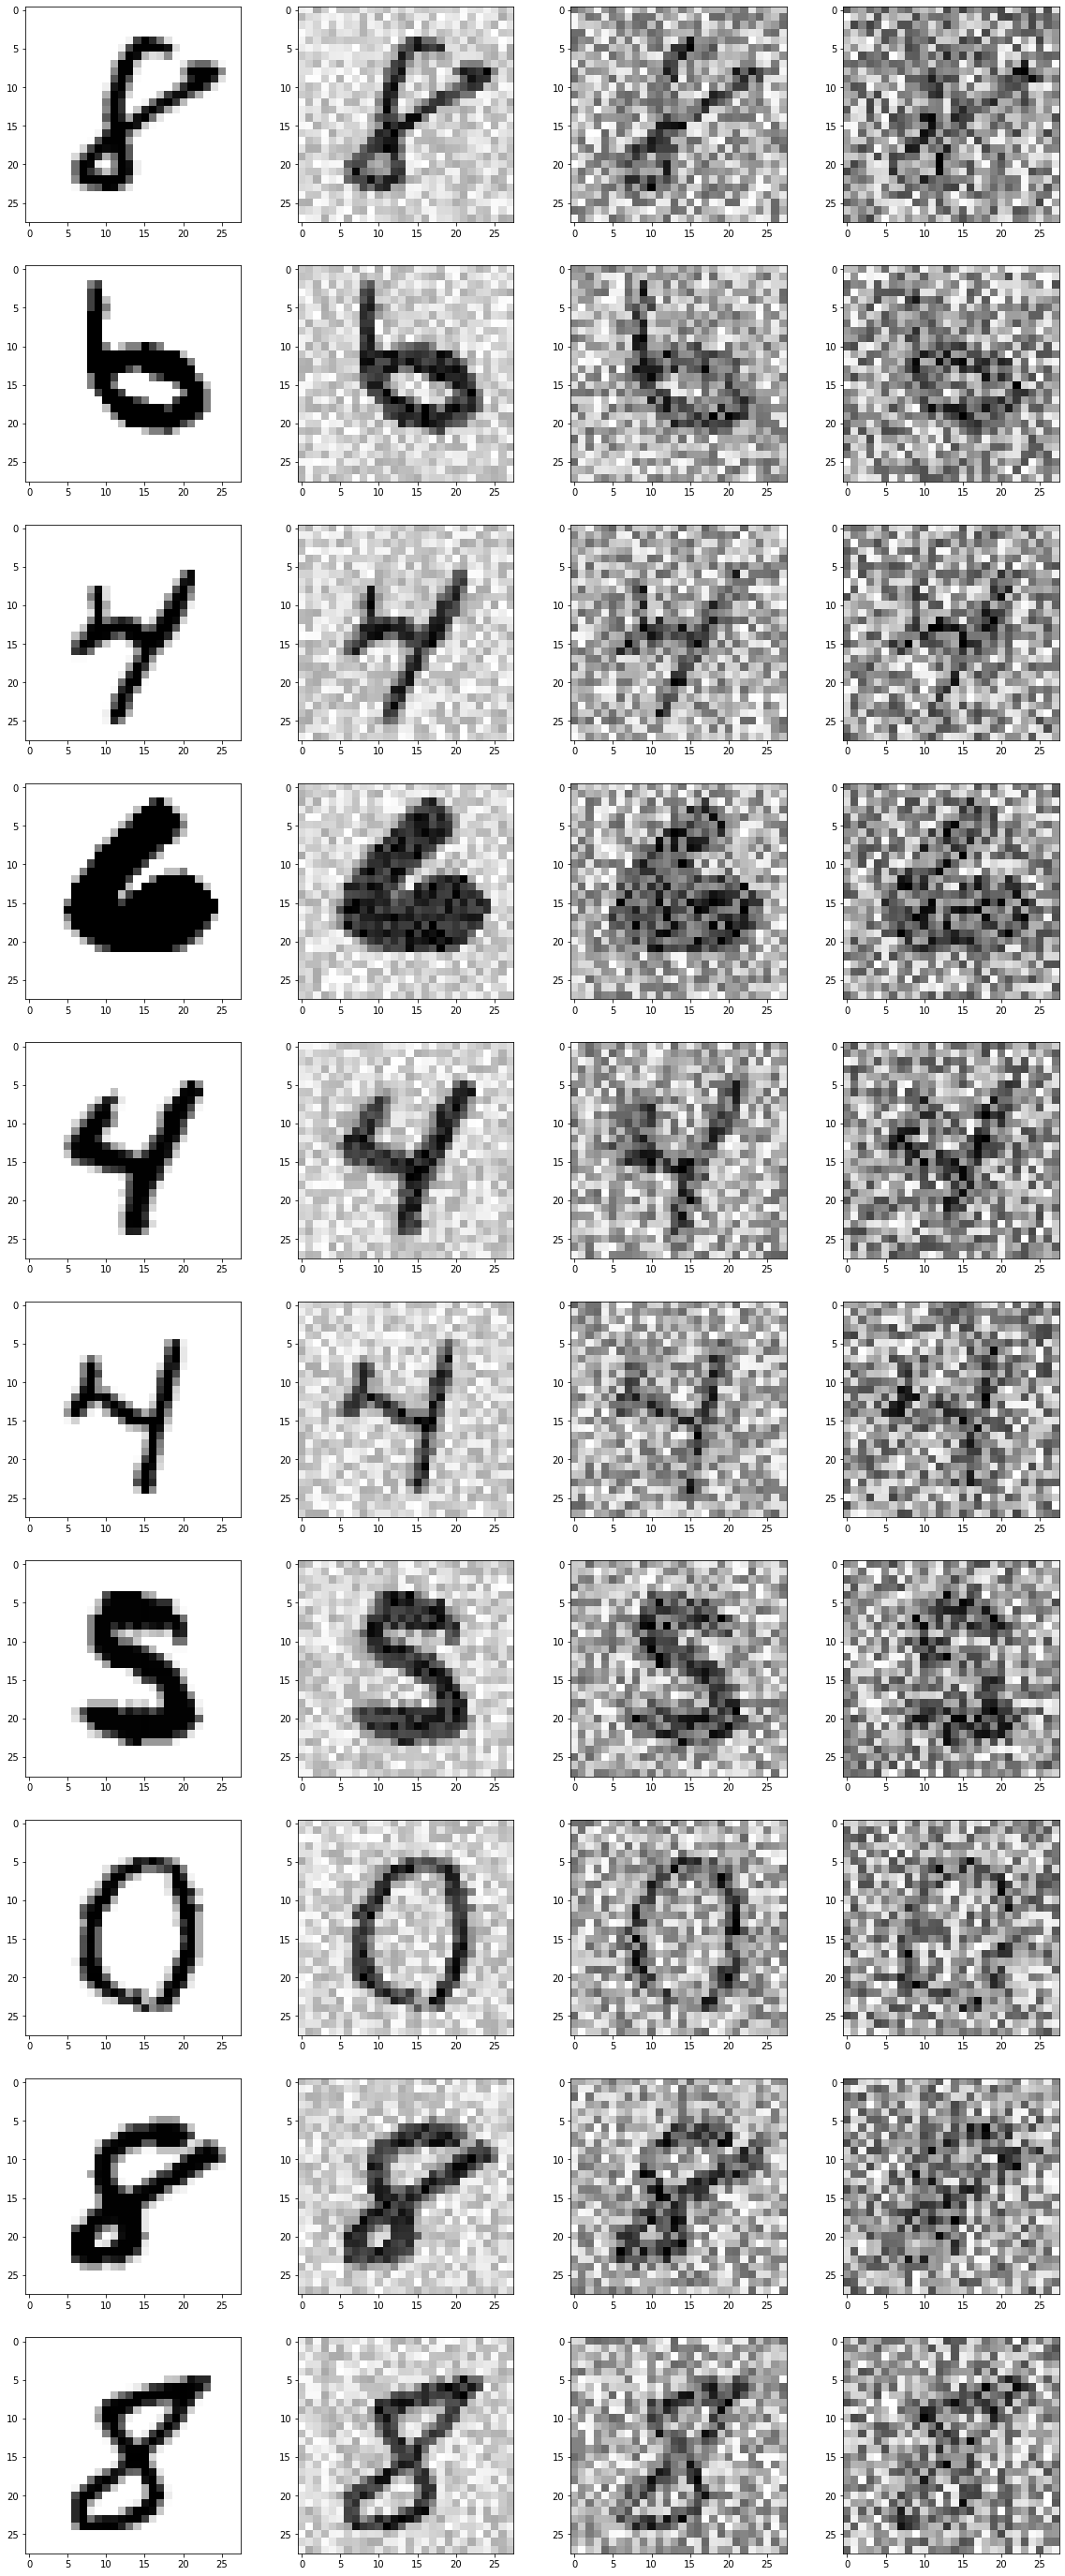

In [12]:
# Отрисуем получившиеся "шумные" изображения

f = plt.figure(figsize=(20, 50))
ncols = 4

for i in range(batch.shape[0]):
    ax = f.add_subplot(batch.shape[0], ncols, i*ncols+1)
    plt.imshow(batch[i], cmap = matplotlib.cm.binary)
    ax = f.add_subplot(batch.shape[0], ncols, i*ncols+2)
    plt.imshow(batch_salted_1[i], cmap = matplotlib.cm.binary)
    ax = f.add_subplot(batch.shape[0], ncols, i*ncols+3)
    plt.imshow(batch_salted_3[i], cmap = matplotlib.cm.binary)
    ax = f.add_subplot(batch.shape[0], ncols, i*ncols+4)
    plt.imshow(batch_salted_5[i], cmap = matplotlib.cm.binary)

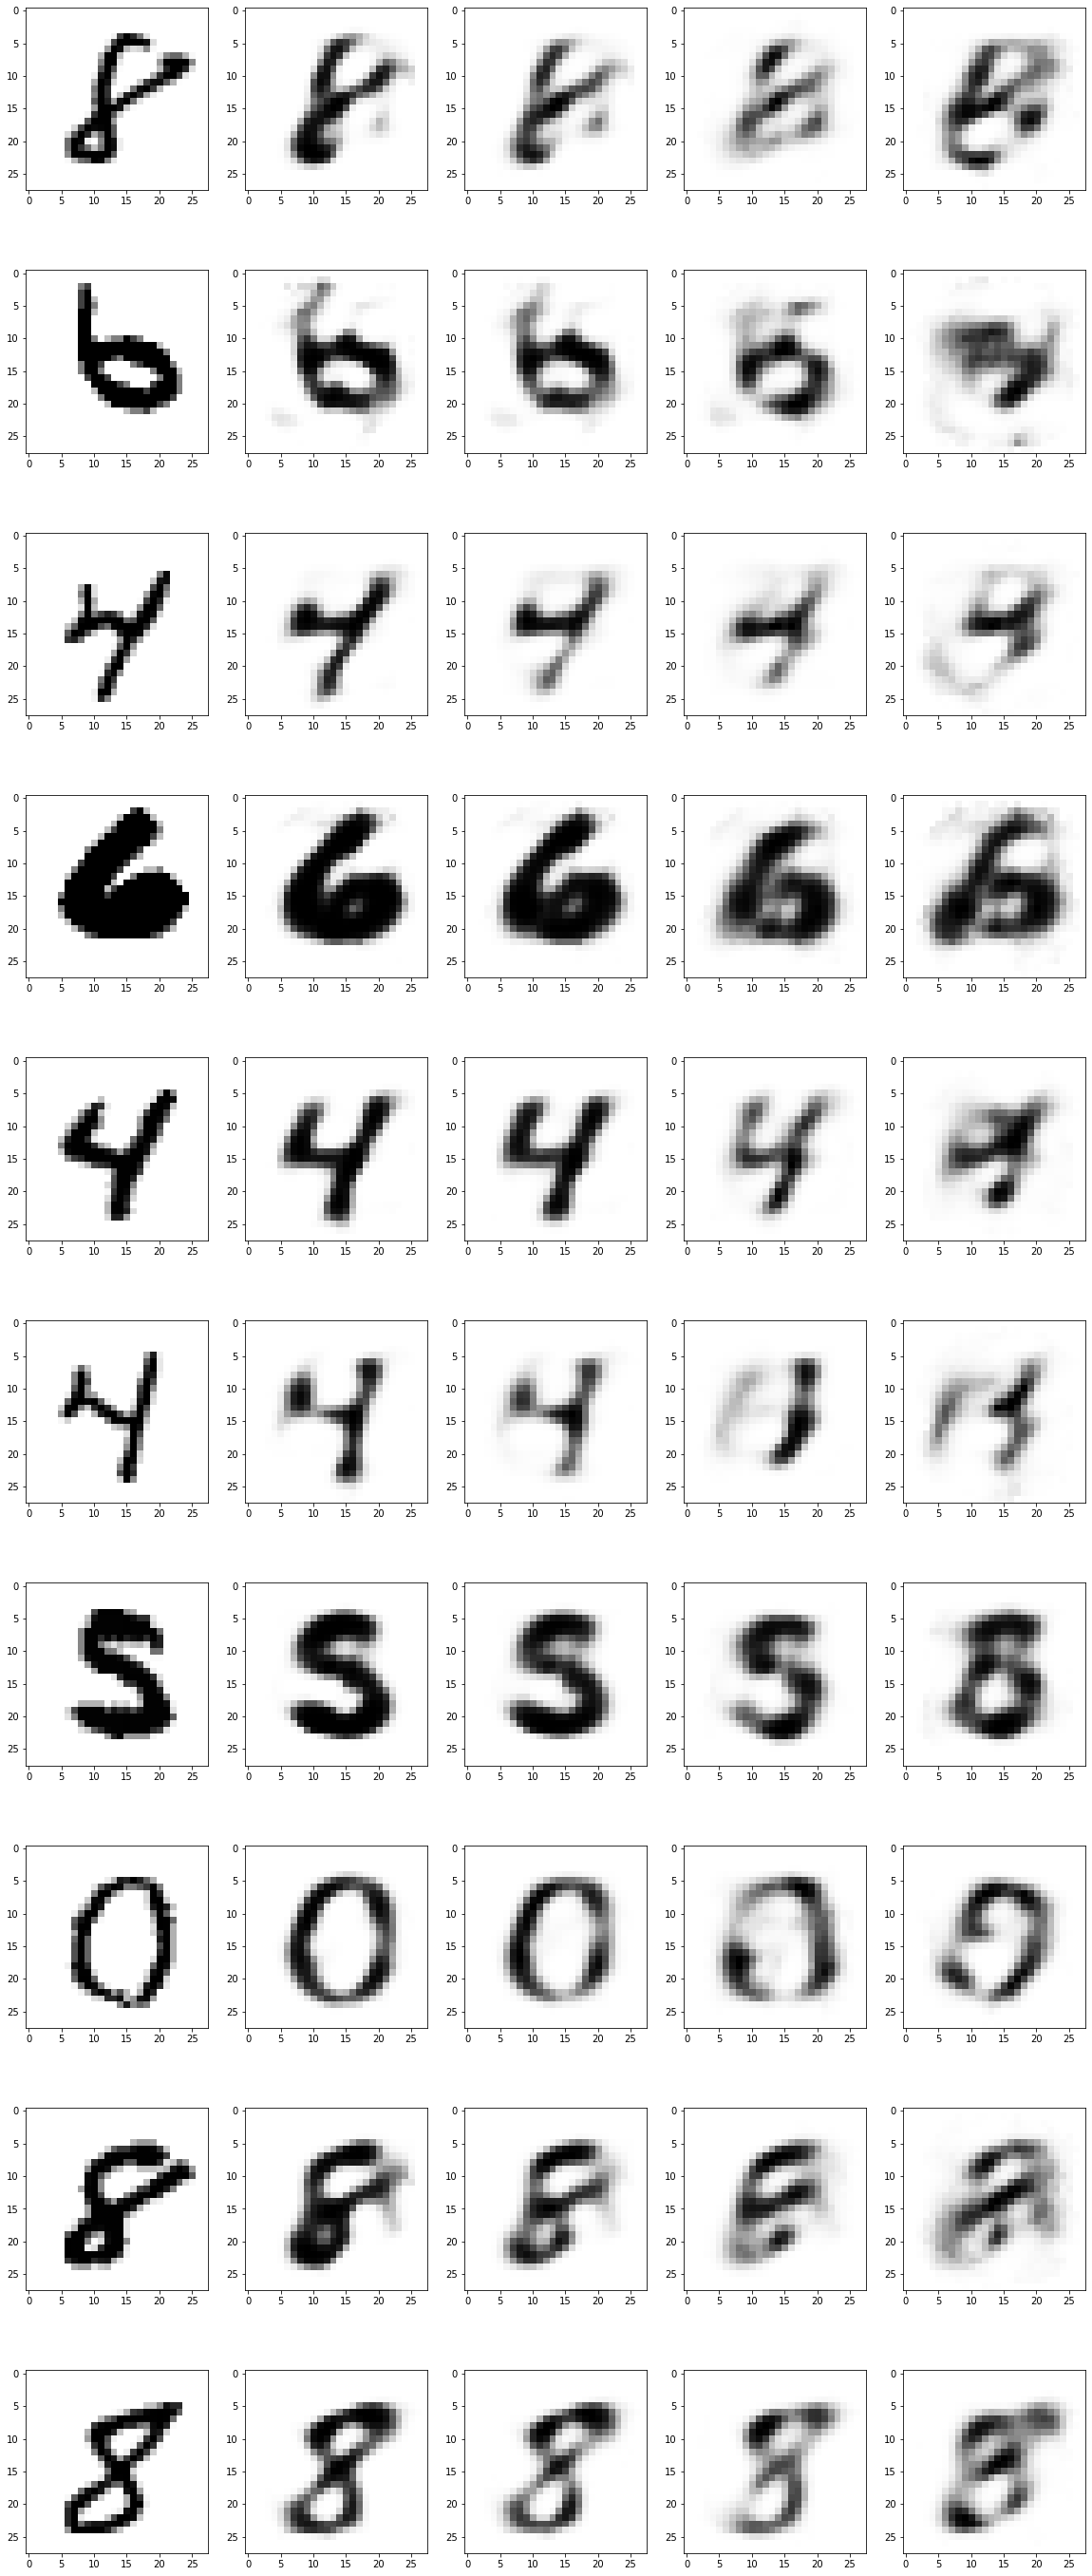

In [13]:
# Отрисуем получившиеся восстановленные изображения

f = plt.figure(figsize=(20, 50))
ncols = 5

for i, (source_img, reconstructed_img, desalted_img_1, desalted_img_3, desalted_img_5) in enumerate(zip(*images)):
    ax = f.add_subplot(batch.shape[0], ncols, i*ncols+1)
    plt.imshow(source_img, cmap = matplotlib.cm.binary)
    ax = f.add_subplot(batch.shape[0], ncols, i*ncols+2)
    plt.imshow(reconstructed_img, cmap = matplotlib.cm.binary)
    ax = f.add_subplot(batch.shape[0], ncols, i*ncols+3)
    plt.imshow(desalted_img_1, cmap = matplotlib.cm.binary)
    ax = f.add_subplot(batch.shape[0], ncols, i*ncols+4)
    plt.imshow(desalted_img_3, cmap = matplotlib.cm.binary)
    ax = f.add_subplot(batch.shape[0], ncols, i*ncols+5)
    plt.imshow(desalted_img_5, cmap = matplotlib.cm.binary)

### Выводы:
* Автокодировщик способен справиться с умереным зашумлением картинки
* Автокодировщик перестаёт справляться с зашумлением, когда цифра плохо различима глазом

### Сделать отражение части изображения

In [14]:
batch, _ = next(iter(testset))

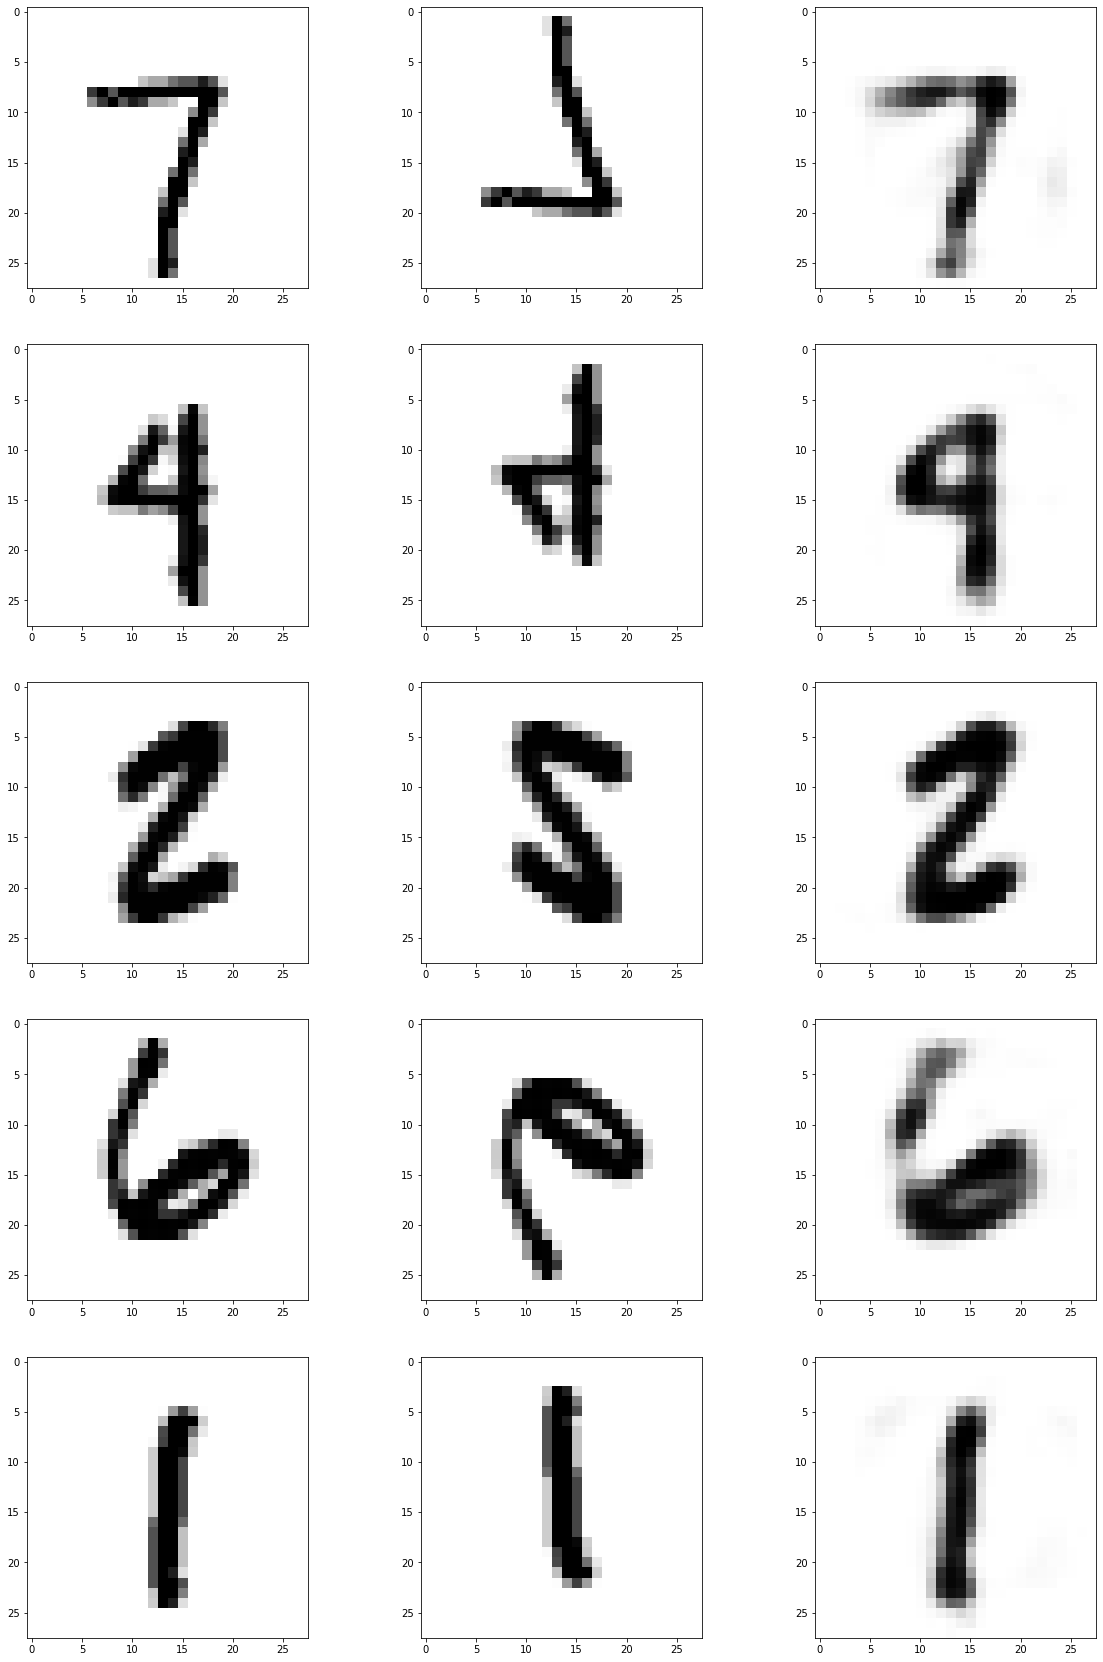

In [15]:
f = plt.figure(figsize=(20, 30))

num_images = 5

for i, img in enumerate(batch[:num_images]):
    
    img = img.view(28, 28)
    mirrored_img = img.view(28, 28).numpy()[::-1]
    decoded_img = models[0](img.cuda()).view(28,28).cpu().detach().numpy()
    
    ax = f.add_subplot(num_images, 3, i*3+1)
    plt.imshow(img, cmap = matplotlib.cm.binary)
    
    ax = f.add_subplot(num_images, 3, i*3+2)
    plt.imshow(mirrored_img, cmap = matplotlib.cm.binary)
    
    ax = f.add_subplot(num_images, 3, i*3+3)
    plt.imshow(decoded_img, cmap = matplotlib.cm.binary)

### Вывод:
* Автокодировщик отлично справляется с "отзеркаливанием"

### Отрисовать карты активаций нейронов скрытого слоя

In [77]:
# массив изображений, доставляющих макимум активаций нейрона. По одному изображению на нейрон.
imgs = []

for neuron_n in range(10):
    
    # случайное изображение, которое мы будем оптимизировать
    img = torch.tensor((np.random.rand(1, 1, 28, 28) - .5)/.5, dtype=torch.float, requires_grad=True)
    
    # Тренируем изображение
    adam = torch.optim.Adam([img], lr=5e-3)
    
    for i in range(20000):
        adam.zero_grad()
            
        # Вычисляем тангенс от изображеня для контроля диапазона значений параметров
        img_tanh = torch.tanh(img)
        
        # максимизируем активацию первого латентного нейрона, лосс ей противоположен
        loss = -models[1].E(img_tanh.view([-1, 28*28]).cuda())[0][neuron_n]
        
        # 
        loss.backward()
        adam.step()

    imgs.append(img_tanh.view(28, 28).detach().numpy())

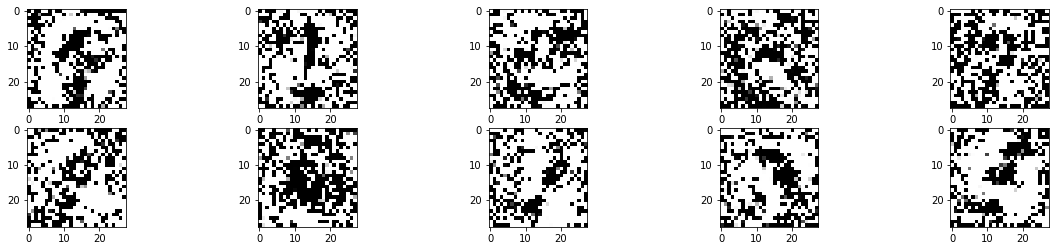

In [102]:
f = plt.figure(figsize=(20, 4))

for i, img in enumerate(imgs):
    ax = f.add_subplot(2, 5, i+1)
    plt.imshow(img+.5, cmap = matplotlib.cm.binary)

Ну, сложно что-то сказать.<br> Эти изображения не похожи на цифры, в то же время, не похожи и на случайный шум.<br> Вот такие картинки доставляют максимум активации нашим нейронам скрытого слоя.<br> Убедимся в этом.

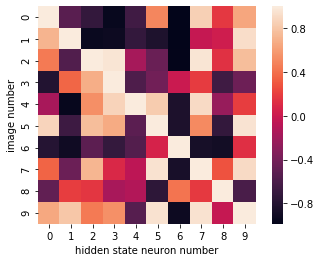

In [101]:
arr_activations = []

for i in range(10):
    response = models[1].E(torch.Tensor(imgs[i]).view([-1, 28*28]).cuda()).cpu().detach().numpy()
    arr_activations.append(response)

sns.heatmap(np.vstack(arr_activations), square=True)
plt.xlabel('hidden state neuron number')
plt.ylabel('image number')
plt.show()

Тут видим, что действительно, картинка с индексом i доставляет максимум активации нейрону и таким же номером. А активации остальных нейронов похожи на случайные. Мы действительно добились цели.